In [5]:
!pip install tensorflow opencv-python matplotlib

You should consider upgrading via the 'C:\Users\Hrvoje\source\repos\DeepLearningIris\DeepLearningIris\Scripts\python.exe -m pip install --upgrade pip' command.


COLLECT IMAGES

In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plot

In [2]:
# LOAD DATA
# Load images

def image_load(x):
    return tf.io.decode_jpeg(tf.io.read_file(x))

In [3]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(image_load)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(image_load)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(image_load)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

In [4]:
# Prepare labels

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [5]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [6]:
# Combine labels and images

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


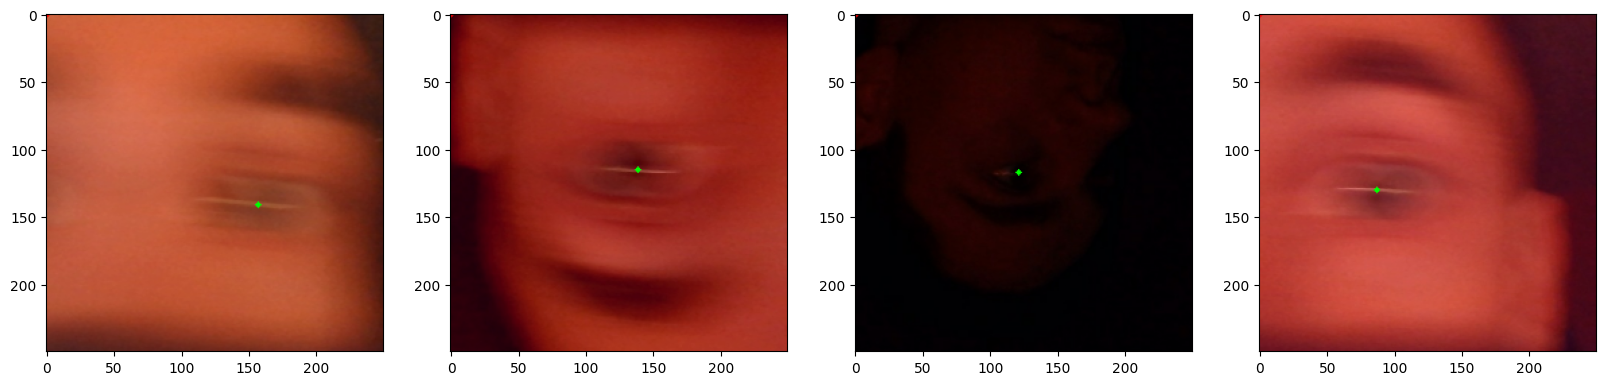

In [8]:
# Print samples

data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plot.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [9]:
# BUILD MODEL
# Make CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [10]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

model.summary()



234545216/234545216 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                    

In [12]:
# Losses and optimization

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss)

In [13]:
# Check predictions

X, y = train.as_numpy_iterator().next()
X.shape
scores = model.predict(X)
scores

1/1 [==============================] - 7s 7s/step


array([[ 0.40624744, -0.56354654,  0.37394643, -0.35270154],
       [-0.1208677 , -0.02441195,  0.6483519 , -0.7493527 ],
       [-0.14082444, -0.5787335 ,  0.6777705 , -1.0764364 ],
       [-0.05179222, -0.10515403,  0.45108306, -0.21520415],
       [-0.35085067, -0.6016945 ,  0.6158736 , -0.8259266 ],
       [ 0.50270414, -0.3291631 , -0.01711428, -0.7174731 ],
       [ 0.69118565,  0.13686877,  0.1626885 , -0.5407783 ],
       [ 0.20865905,  0.03694224,  0.43952197, -0.45721924],
       [-0.05340846, -0.17483   ,  0.5603877 , -1.3491507 ],
       [ 0.03670046, -0.09987638,  0.37927482, -0.08678727],
       [ 0.6252334 ,  0.07402617,  0.18560141, -0.06141996],
       [ 0.645561  , -0.27758476,  0.50422573, -0.71120447],
       [ 0.01760885,  0.34138066,  0.7277723 , -1.1641747 ],
       [ 0.50590336, -0.13059139,  0.23314938, -0.13591376],
       [ 0.14230505, -0.11607175,  0.06640071, -0.7476754 ],
       [ 0.54036856, -0.19331867,  0.7467587 , -0.13811867]],
      dtype=float32)

In [15]:
# Train model

hist = model.fit(train, epochs = 1, validation_data = val)

53/53 [==============================] - 897s 17s/step - loss: 0.0699 - val_loss: 17320.0723


In [ ]:
# PERFORMANCE REVIEW
# Loss plots

hist.history
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [ ]:
# Make test data predictions

test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
fig, ax = plot.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [ ]:
# Save model

from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')
model = load_model('eyetrackerresnet.h5')
model.predict(test_sample[0])

In [ ]:
# REAL TIME DETECTION

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()